In [9]:
%matplotlib inline

import numpy as np

title = "LinkedIn"
fn = "linkedin"
with open(fn + "_normalized.txt", "r") as f:
    data = f.read().splitlines()

data = [i.split() for i in data]
print("Number of rows:", len(data))
print(data[0])

Number of rows: 2446
['Mon', 'Apr', '04', '2016', '03:22:20', 'GMT+0000']


Assume that mail is sent only once per day; average the time in seconds as the actual time of the incoming mail.

In [10]:
import pandas as pd

to_mm = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}

def time_to_hours(s):
    h, m, s = s.split(":")
    h = int(h)
    m = int(m) / 60
    s = int(s) / 3600
    return h + m + s

day_dict = {}
day_dict_count = {}

for d in data:
    day_id = d[1] + d[2] + d[3]

    if day_id in day_dict:
        day_dict[day_id] += time_to_hours(d[4])
        day_dict_count[day_id] += 1

    else:
        day_dict[day_id] = time_to_hours(d[4])
        day_dict_count[day_id] = 1

data_r = np.array([day_dict[d] / day_dict_count[d] for d in day_dict.keys()])
data_r_ts = np.array([pd.Timestamp(int(d[-4:]), to_mm[d[:3]], int(d[3:5])) for d in day_dict.keys()])
print("Reduced rows:", len(data_r))
print(data_r[:5])

Reduced rows: 356
[  8.06604167   0.64986111  13.95224206   3.29641204  10.9774537 ]


In [11]:
print(3600 * 15)
print(3600 * 17)

54000
61200


In [12]:
pre = np.hstack((data_r_ts.reshape(-1, 1), data_r.reshape(-1, 1)))
df = pd.DataFrame(pre[:, 1], columns=["Time"], index=pre[:, 0])
df = df.sort_index()

df.to_csv("test.csv")
df.head()

,Time
2016-03-07,8.21167
2016-03-08,9.53785
2016-03-09,7.45495
2016-03-11,2.00472
2016-03-14,11.0565


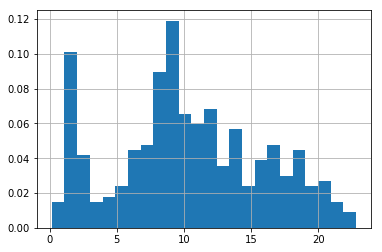

In [13]:
ax = df.Time.hist(normed=True, bins=24)

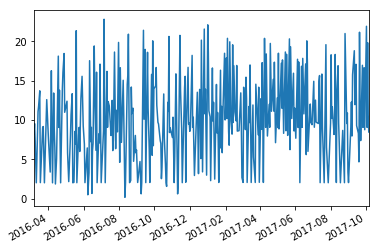

In [14]:
df.Time.plot()

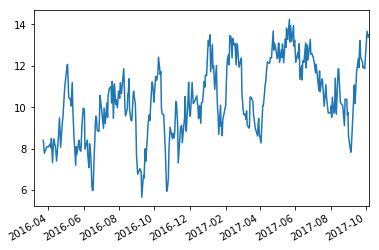

In [15]:
r = df.Time.rolling(window=10)
r.mean().plot()

Trying to visualise the distribution like a clock since time is cyclic.

The idea below is to first normalize the time values $v$ (i.e. hours from midnight of the day on which the email is sent) to circular cartesian coordinates. This is done by setting $0 \rightarrow 0$ and $24 \rightarrow 2\pi$. Since $0 = 2\pi$, then we can better cluster the points which are at midnight. We can convert the values to the $0$ to $2\pi$ range by using the equation $$ \hat{v} = 2\pi \frac{v}{24} $$

So we want a relatively large circle radius to draw the clock numbers within. But all the points are going to cluster very closely only around the circumference of the circle. To better visualize the point distribution, we will add some random noise to the circle radius, keeping the angle of the points (i.e. the representative time of the email being sent) while spreading the points out showing how many points are around that time. To calculate the cartesian coordinates of the circle we use the equations $$ x = r \cos(\hat{v}) $$ $$ y = r \sin(\hat{v}) $$

The graph is colored to show the chronological position of the emails. Darker points are earlier while brighter points are later.

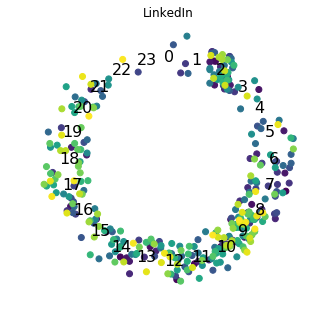

In [17]:
import matplotlib.pyplot as plt

twopi = 2 * np.pi
v = df.Time.values.astype(np.float)
v_hat = v / 24 * twopi

x_noise = np.random.uniform(size=df.Time.values.shape[0]) + 1.75
# x_noise = 2
y_noise = np.random.uniform(size=df.Time.values.shape[0]) + 1.75
# y_noise = 2

x = x_noise * np.cos(v_hat)
y = y_noise * np.sin(v_hat)

plt.figure(figsize=(5,5))

a = 2.25
for i in range(24):
    i_hat = i / 24 * twopi
    lx = a * np.cos(i_hat) - .1
    ly = a * np.sin(i_hat) - .1
    plt.annotate(str(i), xy=(ly, lx), fontsize=16)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axis('off')
plt.title(title)
plt.scatter(y, x, c=df.index)
plt.savefig(fn + ".svg")